## Подсчёт площади дорог

Данные:
- скрин google maps с разметкой дорог и заведений (режим labels on) в достаточно крупном масштабе (если три раза нажать на плюсик, просмотр перейдёт в режим street view)
- такой же скрин, но без разметки, то есть в режиме labels off

Эвристики:
- дороги в рамках одной фотографии имеют характерный цвет (асфальта)
- на изображении с разметкой дороги выделены допольнительным полупрозрачным слоем, надоженным поверх исходного изображения

Решение:
- построим маску полупрозрачного слоя вычитанием двух картинок
- облагородим с помощью небольшого количества ~~томатной пасты для вязкости~~ cvшных методов
- по гистограмме найдём маску того, что похоже на дороги
- пересечём две маски, получив из первой достоверную разметку дорог, а из второй "форму" дорожного полотна, в которой собственно содержится информация о площади

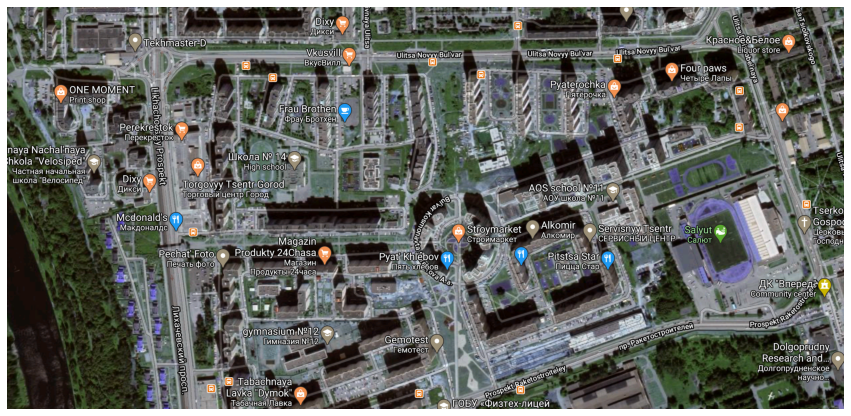

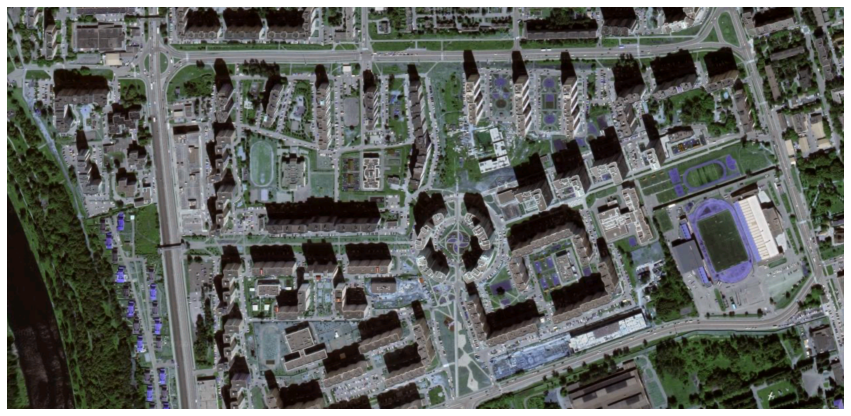

In [71]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)

crop_tl = (400, 0)
crop_br = (1600, 2500)

labels_on  = cv2.imread ("labels_on.png")   [crop_tl [0] : crop_br [0], crop_tl [1] : crop_br [1]]
labels_off = cv2.imread ("labels_off.png")  [crop_tl [0] : crop_br [0], crop_tl [1] : crop_br [1]]

plt.imshow (labels_on)
plt.axis ('off')
plt.show ()

plt.imshow (labels_off)
plt.axis ('off')
plt.show ()

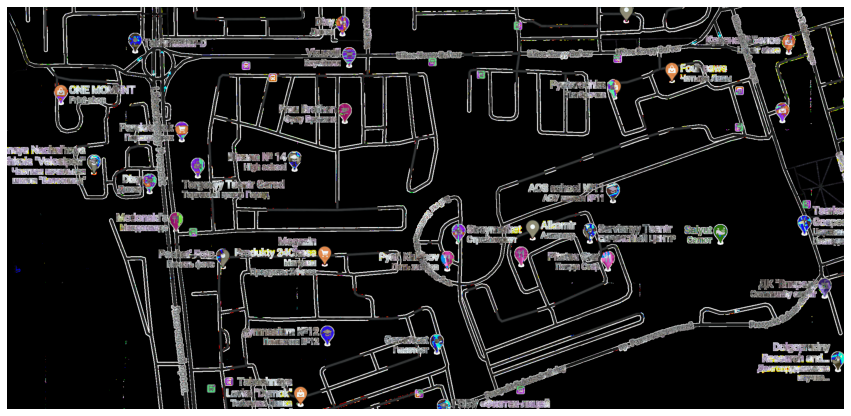

In [72]:
diff = np.abs (labels_on - labels_off)

plt.imshow (diff)
plt.axis ('off')
plt.show ()

Посмотрим на распределение. Где-то после 160 по всем каналам пискелей становится мало, а поскольку дорог много, они скорее всего не там =D

P.S. трешхолды по разным каналам не обязаны совпадать, у меня это в деморежиме так сделано

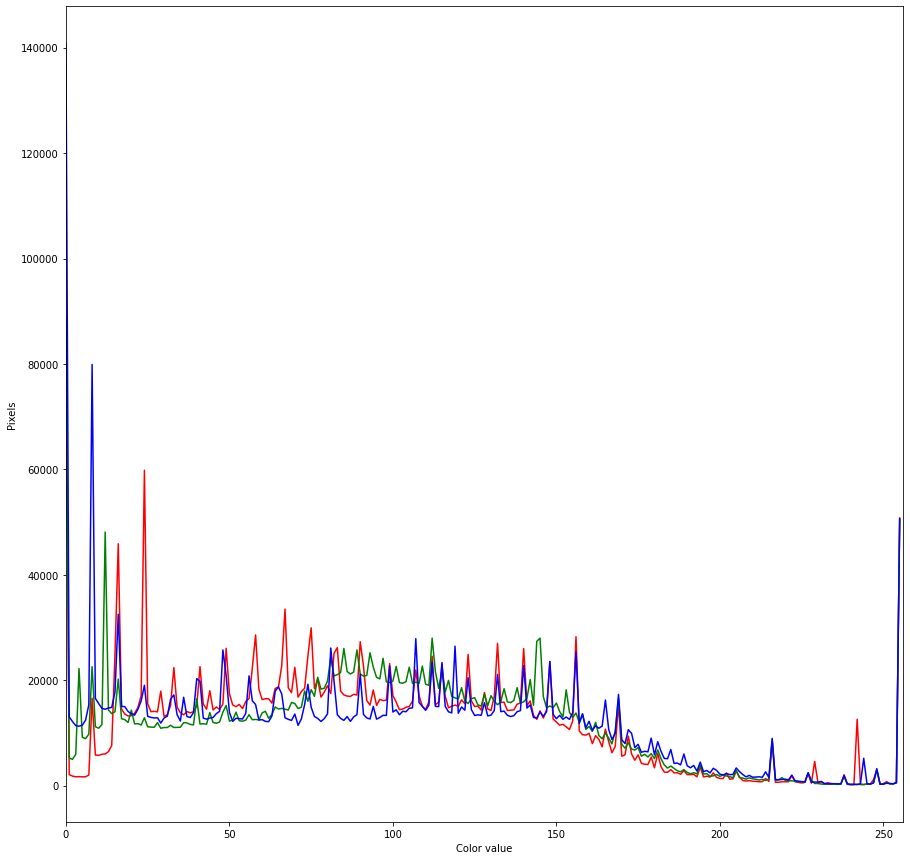

In [73]:
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        labels_on[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

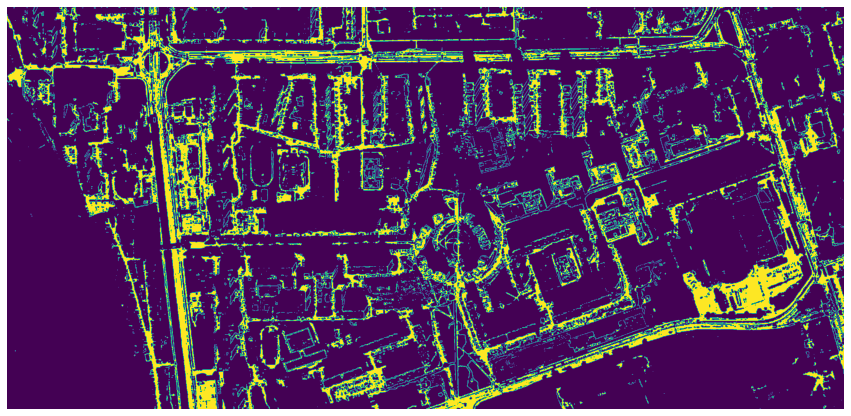

In [74]:
lth = 130
hth = 170

massk = cv2.inRange (labels_off, (lth, lth, lth), (hth, hth, hth))

plt.imshow (massk)
plt.axis ('off')
plt.show ()

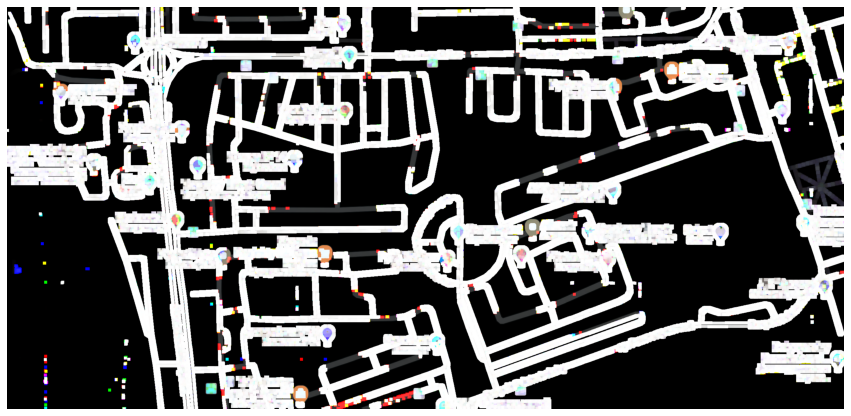

In [75]:
kernel = np.ones ((9, 9), np.uint8)

diff_morph = cv2.morphologyEx (diff, cv2.MORPH_DILATE, kernel)

plt.imshow (diff_morph)
plt.axis ('off')
plt.show ()

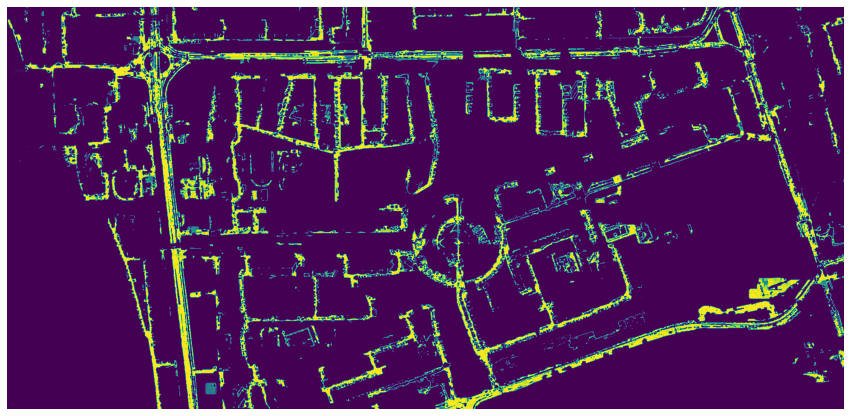

In [76]:
#plt.imshow (cv2.bitwise_and (diff [:, :, 0], massk))
#plt.axis ('off')
#plt.show ()

intersection = cv2.bitwise_and (diff_morph [:, :, 0], massk)

plt.imshow (intersection)
plt.axis ('off')
plt.show ()

# plt.imshow (intersection [10 : 120, 10 : 120])
# plt.axis ('off')
# plt.show ()

In [69]:
whole_area = intersection.shape [0] * intersection.shape [1]

road_area = cv2.countNonZero (intersection)

print (whole_area, road_area, road_area / whole_area)

3000000 307423 0.10247433333333333
